In [ ]:
import os
import warnings
import hashlib
import seaborn as sns
from supabase import create_client, Client
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from tqdm import tqdm

# mute warnings

warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")
load_dotenv()

True

In [2]:
url: str = os.getenv("SUPABASE_URL")
key: str = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [3]:
def get_all_data_paginated(table_name: str, page_size: int = 9999):
        all_data = []
        offset = 0
        while True:
            response = supabase.from_(table_name).select("*").range(offset, offset + page_size - 1).execute()
            data = response.data
            if not data:
                break
            all_data.extend(data)
            offset += page_size
        return all_data

In [4]:
trips = get_all_data_paginated("trips")
df = pd.DataFrame(trips)
print(f"Number of days in the dataset: {df['date'].nunique()}")

Number of days in the dataset: 60


In [ ]:
# format columns
df.rename(columns={
    'id': 'sub_trip_id',
    'station_name': 'current_station',}, inplace=True)
df['date'] = pd.to_datetime(df['date']).dt.date
df['theorical_arrival_time'] = pd.to_datetime(df['theorical_arrival_time']).dt.time
df['theorical_departure_time'] = pd.to_datetime(df['theorical_departure_time']).dt.time
df['actual_arrival_time'] = pd.to_datetime(df['actual_arrival_time']).dt.time
df['actual_departure_time'] = pd.to_datetime(df['actual_departure_time']).dt.time
df['arrival_hour'] = pd.to_datetime(df['theorical_arrival_time'].astype(str), errors='coerce').dt.hour
df['departure_hour'] = pd.to_datetime(df['theorical_departure_time'].astype(str), errors='coerce').dt.hour

# add extra columns
df['theorical_dwelling_time'] =  (round(pd.to_timedelta(df['theorical_departure_time'].astype(str)) - pd.to_timedelta(df['theorical_arrival_time'].astype(str, errors='ignore'))  ).dt.total_seconds() // 60)
df['actual_dwelling_time'] = (round(pd.to_timedelta(df['actual_departure_time'].astype(str)) - pd.to_timedelta(df['actual_arrival_time'].astype(str, errors='ignore'))  ).dt.total_seconds() // 60)
df['dwelling_delay'] = round((pd.to_timedelta(df["actual_dwelling_time"])- pd.to_timedelta(df["theorical_dwelling_time"]) ).dt.total_seconds() / 60).astype("Int64")


df['trip_id'] = df.apply(lambda row: hashlib.sha256(f"{row['date']}_{row['initial_departure_station']}_{row['final_arrival_station']}_{row['train_id']}".encode()).hexdigest(), axis=1)
df['route'] = df['initial_departure_station'] + ' - ' + df['final_arrival_station']
df['day_of_week'] = pd.to_datetime(df['date']).dt.weekday
df['number_of_stations'] = df.groupby('trip_id')['current_station'].transform('nunique')


# Data Dictionary 
|Column Name|Description|
|---|---|
|trip_id|Unique identifier for the whole trip|
|sub_trip_id|Unique identifier for each sub-trip|
|date|Date of the trip|
|day_of_week|Day of the week for the trip (0=Monday, 6=Sunday)|
|train_id|Identifier for the train|
|train_type|Type of the train (e.g., TGV, TNR)|
|initial_departure_station|Station where the trip starts|
|final_arrival_station|Station where the trip ends|
|route|Route of the trip, formatted as "initial_departure_station - final_arrival_station"|
|current_station|Name of the current station|
|sequence|Sequence number of the station in the trip|
|number_of_stations|Total number of stations in the trip|
|theorical_arrival_time|Theoretical arrival time at the current station|
|theorical_departure_time|Theoretical departure time from the current station|
|theorical_dwelling_time|Theoretical time spent at the current station (in minutes)|
|actual_arrival_time|Actual arrival time at the current station|
|actual_departure_time|Actual departure time from the current station|
|actual_dwelling_time|Actual time spent at the current station (in minutes)|
|arrival_delay|Delay in arrival time compared to the theoretical time (in minutes)|
|departure_delay|Delay in departure time compared to the theoretical time (in minutes)|
|dwelling_delay|Difference between actual and theoretical dwelling time (in minutes)|


In [6]:
df.drop_duplicates(inplace=True)
df.shape

(123452, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123452 entries, 0 to 123451
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       123452 non-null  object 
 1   train_id                   123452 non-null  object 
 2   train_type                 123452 non-null  object 
 3   current_station            123452 non-null  object 
 4   sequence                   123452 non-null  int64  
 5   theorical_arrival_time     111068 non-null  object 
 6   actual_arrival_time        111068 non-null  object 
 7   theorical_departure_time   111068 non-null  object 
 8   actual_departure_time      111068 non-null  object 
 9   initial_departure_station  123452 non-null  object 
 10  final_arrival_station      123452 non-null  object 
 11  departure_delay            111068 non-null  float64
 12  arrival_delay              111068 non-null  float64
 13  sub_trip_id                12

In [8]:
df = df[[
    'trip_id', 'sub_trip_id', 'date', 'day_of_week', 'train_id', 'train_type', 'initial_departure_station', 'final_arrival_station', 'route', 'current_station', 'sequence', 'number_of_stations', 'theorical_arrival_time', 'theorical_departure_time', 'theorical_dwelling_time', 'actual_arrival_time', 'actual_departure_time', 'actual_dwelling_time', 'arrival_delay', 'departure_delay', 'dwelling_delay']]

df.sort_values(by=['date', 'trip_id', 'sequence'], inplace=True)
df.head(10)

,trip_id,sub_trip_id,date,day_of_week,train_id,train_type,initial_departure_station,final_arrival_station,route,current_station,...,number_of_stations,theorical_arrival_time,theorical_departure_time,theorical_dwelling_time,actual_arrival_time,actual_departure_time,actual_dwelling_time,arrival_delay,departure_delay,dwelling_delay
76654,00158ccb35fe270c31c586dc94fcb3ee47a8c0b6c69ac3...,0c71df47ff85a5e4b74d85b85da49849ff571707b71018...,2025-05-18,6,1053,GV,CASA VOYAGEURS,TANGER,CASA VOYAGEURS - TANGER,CASA VOYAGEURS,...,4,NaT,19:00:00,NaN,NaT,19:00:25,NaN,NaN,0.0,<NA>
76655,00158ccb35fe270c31c586dc94fcb3ee47a8c0b6c69ac3...,0f4c572b1cbced95d5bf7595b852d20de91f0984d44f3d...,2025-05-18,6,1053,GV,CASA VOYAGEURS,TANGER,CASA VOYAGEURS - TANGER,RABAT AGDAL,...,4,19:45:00,19:50:00,5.0,19:43:48,19:50:23,6.0,0.0,0.0,0
76656,00158ccb35fe270c31c586dc94fcb3ee47a8c0b6c69ac3...,3d19836faa3fbfb1edd5d1a3cb5a8fd0c39cf9260e35bd...,2025-05-18,6,1053,GV,CASA VOYAGEURS,TANGER,CASA VOYAGEURS - TANGER,KENITRA,...,4,20:17:00,20:20:00,3.0,20:15:37,20:20:22,4.0,0.0,0.0,0
76657,00158ccb35fe270c31c586dc94fcb3ee47a8c0b6c69ac3...,c0e0f8dcfe9c373d1acdefc34abc1ddc4062831af404c9...,2025-05-18,6,1053,GV,CASA VOYAGEURS,TANGER,CASA VOYAGEURS - TANGER,TANGER,...,4,21:10:00,NaT,NaN,21:24:11,NaT,NaN,14.0,NaN,<NA>
76545,035561dd482fd4dd62245ab7e16352d4e0c9c00cc2bc79...,a3adc9d70fd839cfb19adb96b4cd7b298dc46f095792d2...,2025-05-18,6,A11,TNR,CASA PORT,AEROPORT MED V,CASA PORT - AEROPORT MED V,CASA PORT,...,4,NaT,08:50:00,NaN,NaT,08:50:59,NaN,NaN,1.0,<NA>
76546,035561dd482fd4dd62245ab7e16352d4e0c9c00cc2bc79...,b7306a0963aaef83d71916915448a490a0e3bca9fae01c...,2025-05-18,6,A11,TNR,CASA PORT,AEROPORT MED V,CASA PORT - AEROPORT MED V,CASA VOYAGEURS,...,4,09:02:00,09:05:00,3.0,09:02:58,09:05:18,2.0,1.0,0.0,0
76547,035561dd482fd4dd62245ab7e16352d4e0c9c00cc2bc79...,2704eb05250dcdb4f6236b0a5223781cea7622c8650d40...,2025-05-18,6,A11,TNR,CASA PORT,AEROPORT MED V,CASA PORT - AEROPORT MED V,CASA OASIS,...,4,09:11:00,09:12:00,1.0,09:11:18,09:13:00,1.0,0.0,1.0,0
76548,035561dd482fd4dd62245ab7e16352d4e0c9c00cc2bc79...,b364b70c9b9fa6beea6bbece8413af7e921a56fb6f3889...,2025-05-18,6,A11,TNR,CASA PORT,AEROPORT MED V,CASA PORT - AEROPORT MED V,AEROPORT MED V,...,4,09:35:00,NaT,NaN,09:34:38,NaT,NaN,0.0,NaN,<NA>
76119,040f868c2137ae74b7a5957997425b96539ca747ebf5ab...,fc185cc4ff36fc9ed71b6985ff81af05f6d94a78272f77...,2025-05-18,6,501,TLR,FES,TANGER,FES - TANGER,FES,...,12,NaT,11:15:00,NaN,NaT,11:15:00,NaN,NaN,0.0,<NA>
76120,040f868c2137ae74b7a5957997425b96539ca747ebf5ab...,cd46476ad230deaaed5a604ca7c76d58ed9a604c340b35...,2025-05-18,6,501,TLR,FES,TANGER,FES - TANGER,AIN TAOUJDATE,...,12,11:26:00,11:27:00,1.0,11:26:00,11:27:00,1.0,0.0,0.0,0


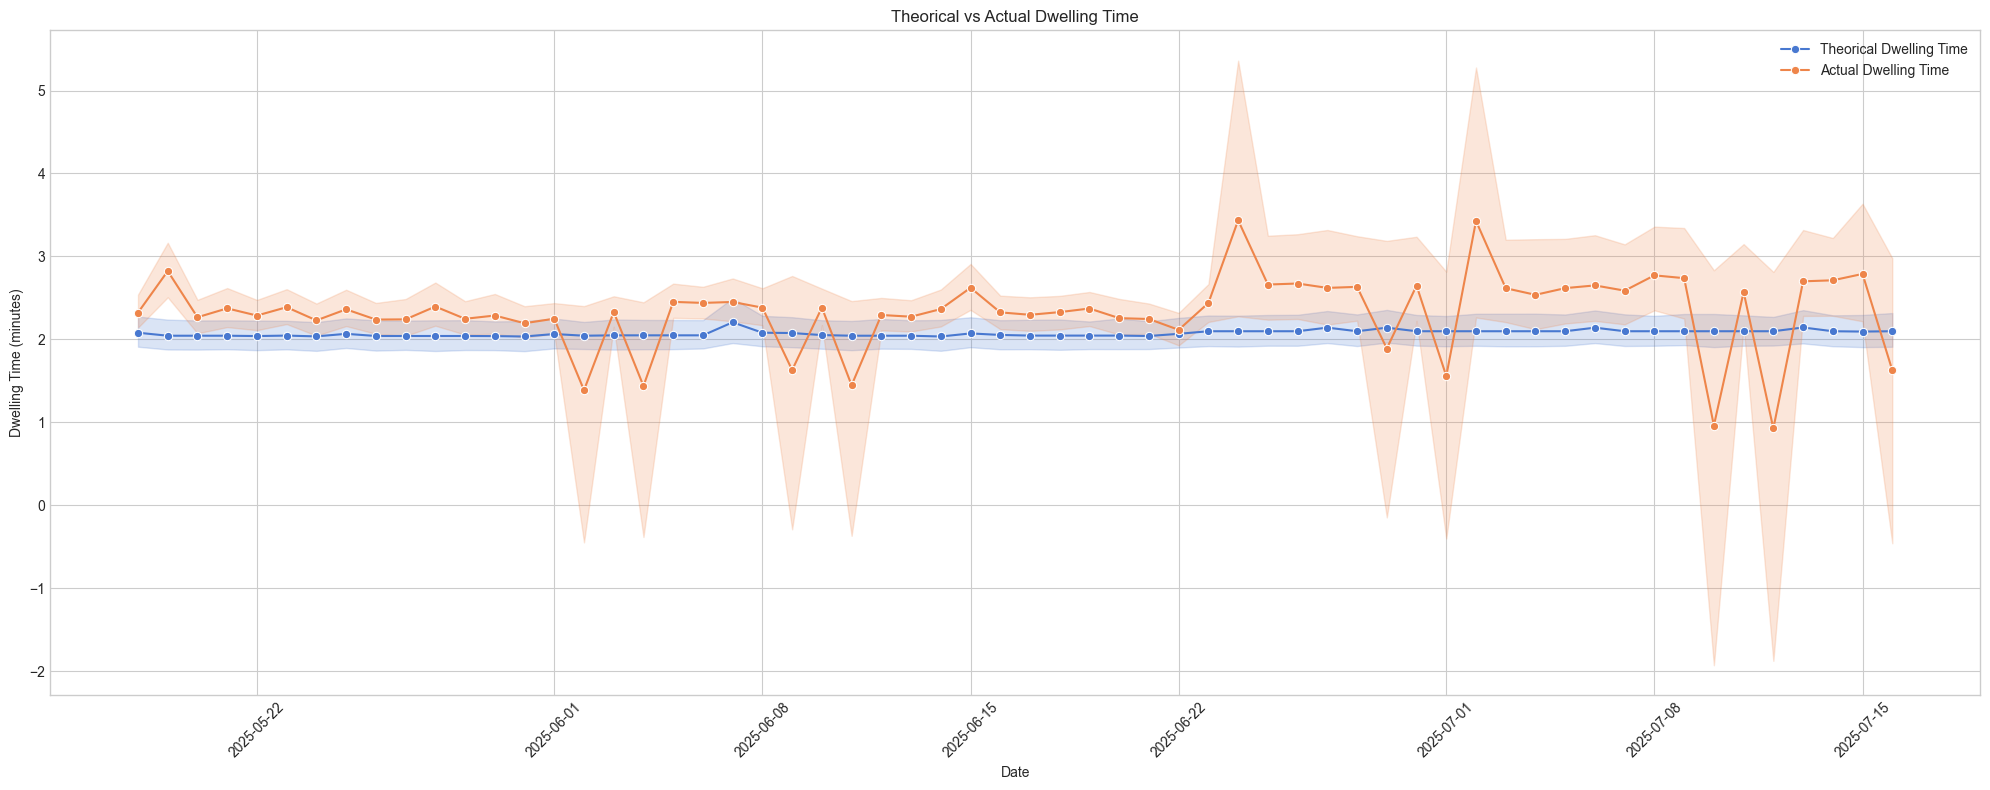

In [9]:
# Difference between theorical and actual dwelling time
plt.figure(figsize=(20, 8))
sns.lineplot(data=df, x='date', y='theorical_dwelling_time', label='Theorical Dwelling Time', marker='o')
sns.lineplot(data=df, x='date', y='actual_dwelling_time', label='Actual Dwelling Time', marker='o')
plt.title('Theorical vs Actual Dwelling Time')
plt.xlabel('Date')
plt.ylabel('Dwelling Time (minutes)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

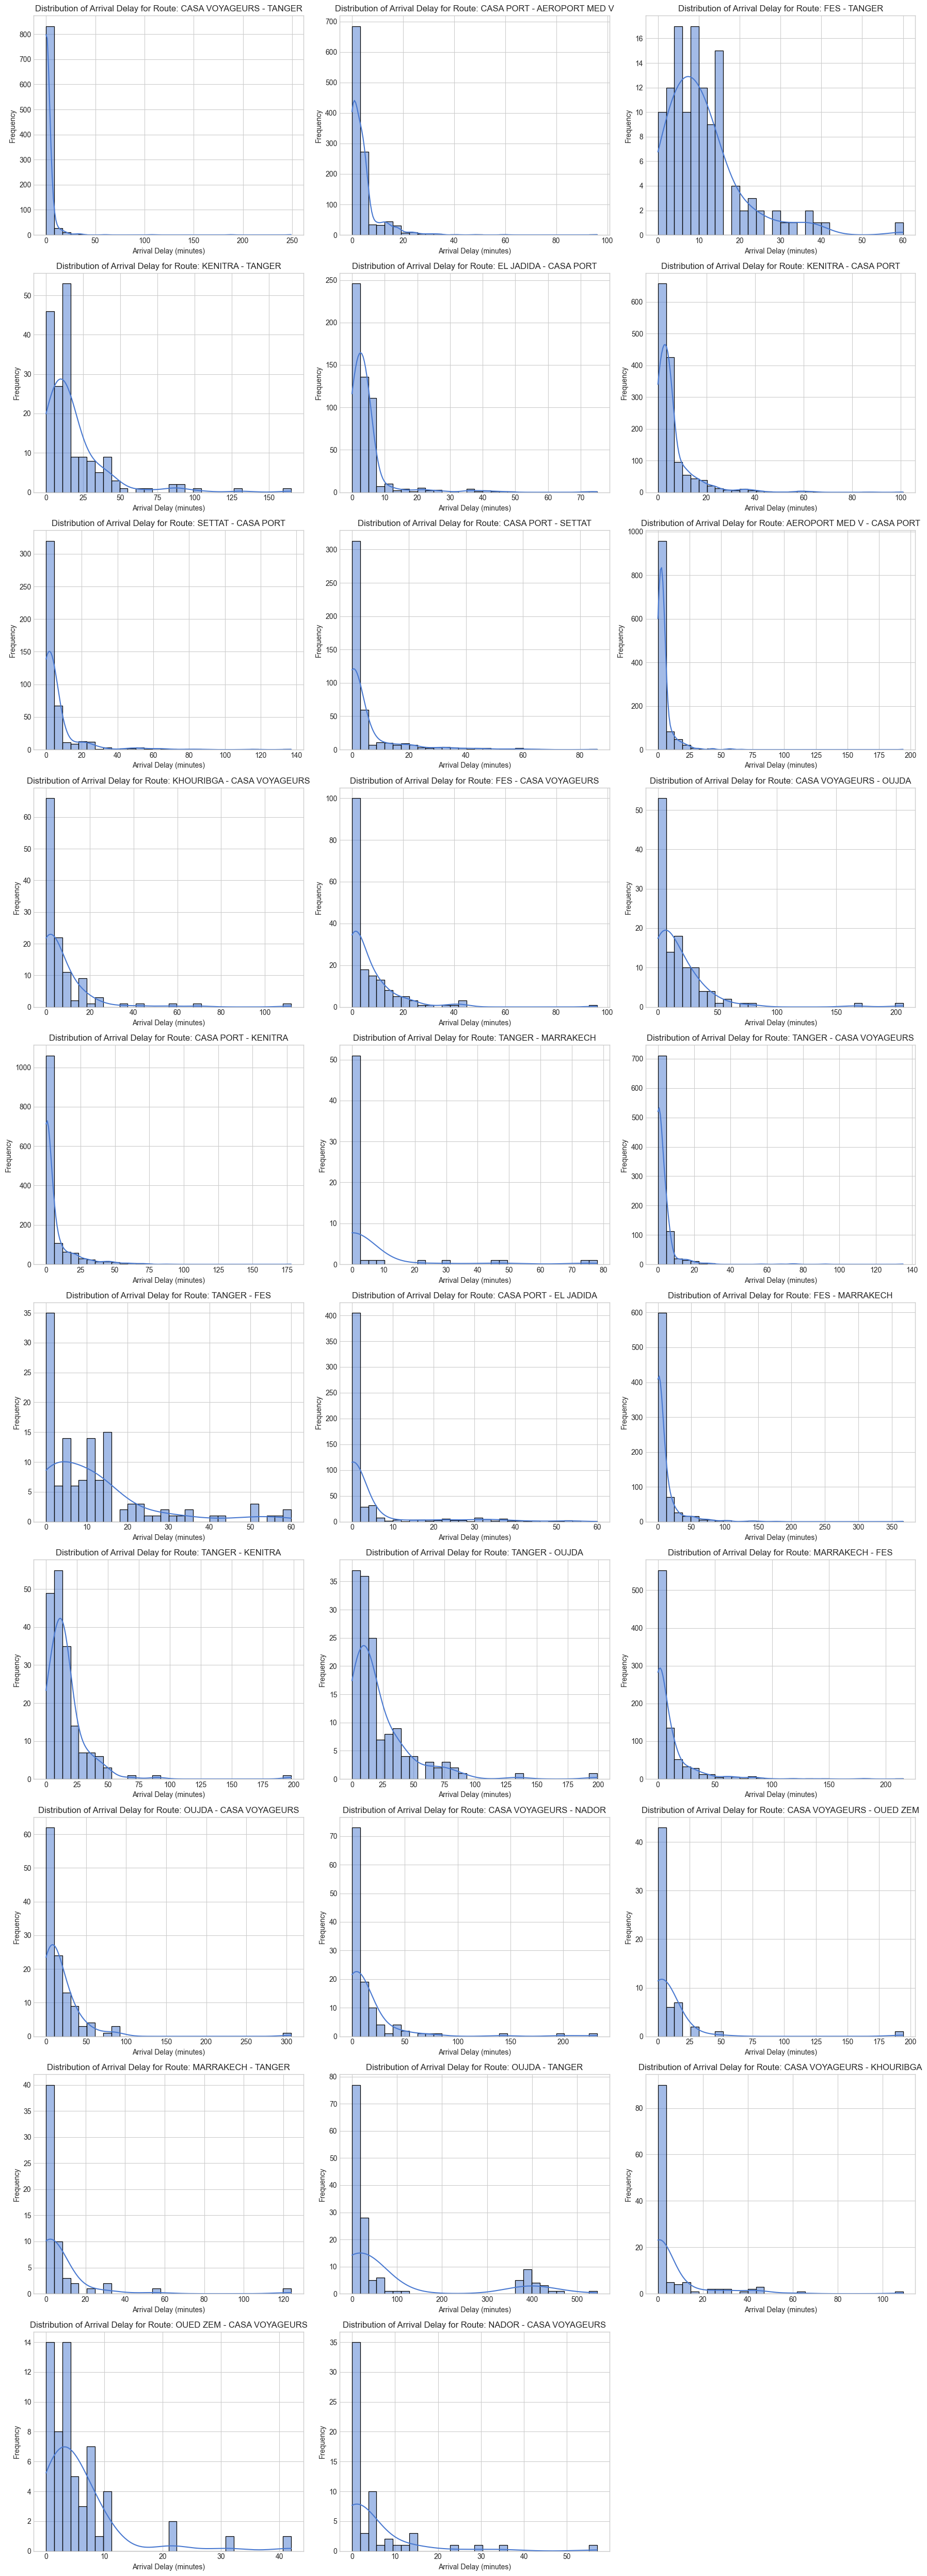

In [10]:
# distribution of delay frequency for each route
routes = df[df.current_station == df.final_arrival_station]['route'].unique()
n_routes = len(routes)
n_cols = 3
n_rows = int(np.ceil(n_routes / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), squeeze=False)
for idx, route in enumerate(routes):
    row, col = divmod(idx, n_cols)
    group = df[(df.current_station == df.final_arrival_station) & (df.route == route)]
    sns.histplot(group['arrival_delay'], bins=30, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of Arrival Delay for Route: {route}')
    axes[row, col].set_xlabel('Arrival Delay (minutes)')
    axes[row, col].set_ylabel('Frequency')

# Hide any unused subplots
for idx in range(n_routes, n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

In [52]:
for col in ['day_of_week', 'arrival_hour', 'train_type', 'route']:
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    stats = df.groupby(col)['arrival_delay'].agg(['mean', 'std', 'count']).reset_index()
    fig.add_trace(
        go.Bar(
            x=stats[col],
            y=stats['mean'],
            name="Average Arrival Delay",
            marker_color='rgb(55, 83, 109)',
            error_y=dict(
                type='data',
                array=stats['std'] / np.sqrt(stats['count']),
                visible=True
            )
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=stats[col],
            y=stats['count'],
            name="Number of Trips",
            mode='lines+markers',
            marker=dict(size=8, color='rgb(227, 119, 194)'),
            line=dict(width=2)
        ),
        secondary_y=True,
    )
    fig.update_layout(
        title_text=f"Average Arrival Delay and Number of Trips by {col.replace('_', ' ').title()}",
        xaxis_title=col.replace('_', ' ').title(),
        yaxis_title="Average Arrival Delay (minutes)",
        yaxis2_title="Number of Trips",
        legend=dict(x=0.8, y=1.2),
        template='plotly_white'
    )
    fig.show()


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123452 entries, 76654 to 123045
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trip_id                    123452 non-null  object 
 1   sub_trip_id                123452 non-null  object 
 2   date                       123452 non-null  object 
 3   day_of_week                123452 non-null  int32  
 4   train_id                   123452 non-null  object 
 5   train_type                 123452 non-null  object 
 6   initial_departure_station  123452 non-null  object 
 7   final_arrival_station      123452 non-null  object 
 8   route                      123452 non-null  object 
 9   current_station            123452 non-null  object 
 10  sequence                   123452 non-null  int64  
 11  number_of_stations         123452 non-null  int64  
 12  theorical_arrival_time     111068 non-null  object 
 13  theorical_departure_time   111

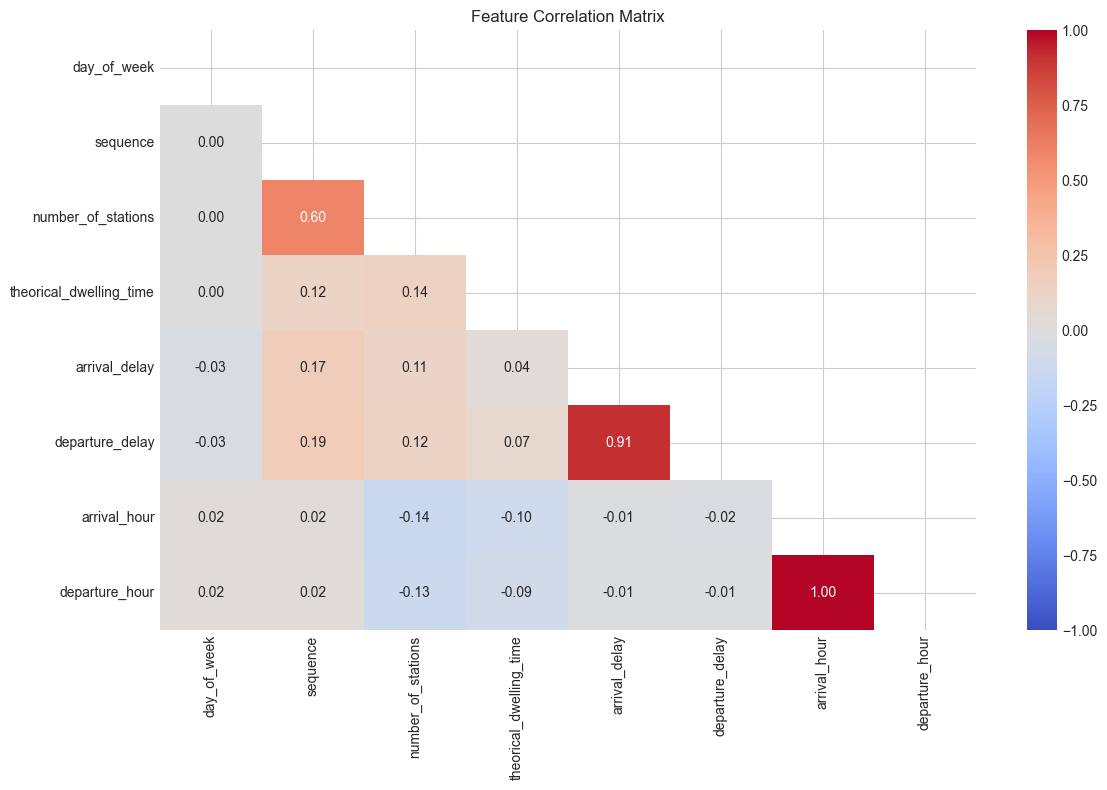

In [61]:
correlation_matrix = df.drop(columns=['actual_dwelling_time', 'dwelling_delay'], axis=1).corr(numeric_only=True)
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()